# Toto Fine-tuning with Exogenous Covariates Tutorial

This notebook demonstrates how to **fine-tune Toto** on domain-specific time series data and leverage **exogenous (known future) covariates** to improve forecasting accuracy.

---

## Notebook Overview

| Section | Description |
|---------|-------------|
| **1. Setup & Imports** | Environment configuration, library imports, and deterministic execution setup. |
| **2. Data Preparation** | Loading a dataset from the FEV Benchmark and defining target/exogenous fields. |
| **3. Fine-tuning** | Configuration, model initialization, and training — both with and without exogenous covariates. |
| **4. Inference** | Building input tensors and generating forecasts from zero-shot and fine-tuned models. |
| **5. Visualization** | Comparing forecast outputs across models in a multi-panel plot. |
| **6. Evaluation** | Quantitative evaluation using GluonTS metrics (MAE, MASE, Quantile Loss). |

---

### Key Concepts

- **Exogenous Covariates**: Known future covariates (e.g., weather forecasts, scheduled events) that can improve predictions when provided at inference time.
- **CausalMaskedTimeseries**: The data structure Toto uses during training, containing context + target slices with padding/ID masks.
- **MaskedTimeseries**: The inference-time input structure containing context series and metadata.

---

## 1. Setup & Imports

First, create and activate a virtual environment with the required dependencies:

```bash
python -m venv env
source env/bin/activate
pip install -r requirements.txt
pip install -e .
```

In [1]:
import datasets
import numpy as np
import os 
import torch
from toto.scripts.benchmark_finetuning import prepare_dataset, parse_field
import yaml
from toto.scripts import finetune_toto as finetune

# These lines make gpu execution in CUDA deterministic
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)

## 2. Data Preparation

We load the **proenfo_gfc12 1-H electricity dataset** from the [FEV Benchmark](https://huggingface.co/datasets/autogluon/fev_datasets), which contains electricity load data along with weather-related exogenous covariates.

Note: To load a custom dataset, make sure the dataset has the format described in [README](../../README.md)


**Dataset fields:**
- `target`: The primary time series to forecast (electricity load)
- `airtemperature`: Exogenous weather covariate that is known in advance

We define transform functions to handle missing values and specify which fields to use as targets vs. exogenous features.

In [2]:
from toto.scripts.benchmark_finetuning import load_config

# load base finetuning config
config_path = "../scripts/configs/finetune_config.yaml"   # modify the config for personal use
base_config = load_config(config_path)

In [3]:
# Load fev benchmark tasks from yaml file
pth = "../evaluation/fev/tasks.yaml"
with open(pth, "r") as f:
    tasks = yaml.safe_load(f)

# extract the configuration for the first task in the benchmark (Example: proenfo_gfc12)
task = tasks["tasks"][0]                # change the index to load different tasks
dataset_name = task["dataset_config"]
target_fields = parse_field(task, "target", default_value=["target"])
ev_fields = parse_field(task, "known_dynamic_columns", default_value=[])
horizon = task["horizon"]
seasonality = task["seasonality"]

# NOTE: to load a custom dataset, make sure the dataset has the format described in README.md

# This example uses one of Fev Benchmark datasets with known exogenous covariates. 
custom_dataset = prepare_dataset(dataset_name, target_fields, ev_fields)

In [4]:
display(custom_dataset)

{'dataset_name': 'proenfo_gfc12',
 'dataset': Dataset({
     features: ['id', 'timestamp', 'target', 'airtemperature'],
     num_rows: 11
 }),
 'target_fields': ['target'],
 'target_transform_fns': [<function toto.scripts.benchmark_finetuning.drop_nan_fn(x: numpy.ndarray, encode_categorical: bool = True) -> numpy.ndarray>],
 'ev_fields': ['airtemperature'],
 'ev_transform_fns': [<function toto.scripts.benchmark_finetuning.drop_nan_fn(x: numpy.ndarray, encode_categorical: bool = True) -> numpy.ndarray>]}

In [5]:
total_length = len(custom_dataset['dataset'][target_fields[0]][0])
print("total series length", total_length)

total series length 39414


## 3. Fine-tuning

### 3.1 Configuration

We define two training configurations:
- **Without exogenous covariates** (`no_ev_config`): Standard fine-tuning on target series only
- **With exogenous covariates** (`ev_config`): Fine-tuning that incorporates known future weather data

In [6]:
from toto.scripts.benchmark_finetuning import get_config 

# get config for no exogenous covariates fine-tuning
no_ev_config = get_config(
    base_config,
    "toto_without_ev",
    custom_dataset["dataset_name"],
    add_exogenous_features=False,
    horizon=horizon,
)

# get config for exogenous covariates fine-tuning
ev_config = get_config(
    base_config,
    "toto_with_ev",
    custom_dataset["dataset_name"],
    add_exogenous_features=True,
    horizon=horizon,
)

### 3.2  Initialize Lightning Modules

`init_lightning()` loads the pretrained Toto model and wraps it in a PyTorch Lightning module for training. It returns:
- `lightning_module`: The model wrapped for fine-tuning with optimizer and scheduler
- `patch_size`: The model's patch size (64 for Toto-Open-Base-1.0), used to compute context length


In [7]:
# initialize lightning modules for no exogenous covariates fine-tuning
lightning_module_wo_ev, patch_size = finetune.init_lightning(no_ev_config)
# initialize lightning modules for exogenous covariates fine-tuning
lightning_module_with_ev, patch_size = finetune.init_lightning(ev_config)

Seed set to 42
Seed set to 42


#### Keep an Unfinetuned Copy for Comparison

We also initialize a separate copy of the pretrained model that we **won't** fine-tune. This serves as our zero-shot baseline for comparing forecast quality.


In [8]:
# keep an unfinetuned copy for comparison
lightning_module_unfinetuned, _ = finetune.init_lightning(no_ev_config)

Seed set to 42


### 3.3 Create Data Modules

`get_datamodule()` creates a PyTorch Lightning DataModule that handles:
- Converting the HuggingFace dataset to GluonTS format
- Splitting data into training and validation sets
- Creating sliding windows with the specified context length
- Building `CausalMaskedTimeseries` batches for training

Setting `setup=True` immediately initializes the datasets (otherwise deferred to trainer).


In [9]:
# prepare finetuned datamodules
datamodule_with_ev = finetune.get_datamodule(ev_config, patch_size, custom_dataset, setup=True)
datamodule_wo_ev = finetune.get_datamodule(no_ev_config, patch_size, custom_dataset, setup=True)

### 3.4 Training

We now train two versions of Toto:
1. **Without exogenous covariates**: The model learns only from the target electricity load series
2. **With exogenous covariates**: The model learns to condition predictions on known future weather data

Both models are trained for the same number of steps to ensure a fair comparison.

Training progress can be monitored via TensorBoard:
```bash
tensorboard --logdir lightning_logs/
```


In [ ]:
# finetune the model without exogenous covariates
_, best_ckpt_path_wo_ev, best_val_loss_wo_ev = finetune.train(lightning_module_wo_ev, datamodule_wo_ev, no_ev_config)

# load the best finetuned model without exogenous covariates
lightning_module_wo_ev = finetune.load_finetuned_toto(no_ev_config["pretrained_model"], best_ckpt_path_wo_ev, lightning_module_wo_ev.device)

In [ ]:
# finetune the model with exogenous covariates
_, best_ckpt_path_ev, best_val_loss_ev = finetune.train(lightning_module_with_ev, datamodule_with_ev, ev_config)

# load the best finetuned model with exogenous covariates
lightning_module_with_ev = finetune.load_finetuned_toto(ev_config["pretrained_model"], best_ckpt_path_ev, lightning_module_with_ev.device)

## 4. Inference

With the models trained, we now generate forecasts from three configurations:
1. **Zero-shot Toto**: The pretrained model without any fine-tuning
2. **Fine-tuned (no exogenous covariates)**: Fine-tuned on target series only
3. **Fine-tuned (with exogenous covariates)**: Fine-tuned with weather data as known future inputs

### 4.1 Building Input Tensors

First, we need to construct `MaskedTimeseries` inputs from the test split. This involves:
- Extracting context (historical) and future (ground truth) windows from the data
- Creating appropriate masks for padding and variable identification
- Optionally including exogenous covariates in the input tensor

In [12]:
from datasets import load_from_disk 
from math import ceil 
import torch 
import numpy as np
from toto.data.util.dataset import MaskedTimeseries

TEST_SPLIT_FRACTION = 0.1

# helper function to build masked timeseries for inference/visualization
def build_masked_timeseries(
    data, 
    patch_size, 
    add_exogenous_variables=True, 
    offset_multiplier=0, 
    context_length=512, 
    max_pred_length=256,
    idx=0,
    device=None
):
    """
    Build a MaskedTimeseries input for Toto inference from raw dataset.
    
    Returns the input tensor, context/future series for visualization,
    timestamps, and the number of exogenous variables.
    """
    series = np.array(data["target"][idx]).reshape(1, -1)
    total_length = series.shape[-1]

    timestamps = np.array(data["timestamp"][idx]).reshape(1, -1)

    if add_exogenous_variables:
        ev_features = np.array(data["feat_dynamic_real"][idx])
        V_ev = ev_features.shape[0]
        # shift exogenous features
        ev_features = ev_features[:, patch_size:]
        ev_features = np.concatenate([ev_features, np.zeros((V_ev, patch_size))], axis=-1)
        mv_series = np.concatenate([series, ev_features], axis=0)
    else:
        V_ev = 0
        mv_series = series

    V_target = series.shape[0]

    offset = offset_multiplier * context_length
    test_split = ceil(TEST_SPLIT_FRACTION * total_length - offset)

    # slicing context and future series
    context_series = mv_series[:, :-test_split][:, -context_length:]
    future_series = mv_series[:, -test_split:][:, :max_pred_length]
    context_series = torch.tensor(context_series, dtype=torch.float32)
    future_series = torch.tensor(future_series, dtype=torch.float32)

    # create padding mask
    padding_mask = torch.ones_like(context_series, dtype=torch.bool)
    if add_exogenous_variables and V_ev > 0:
        padding_mask[V_target:V_target + V_ev, -patch_size:] = False

    # constructing id mask 
    id_mask = torch.ones_like(context_series, dtype=torch.long)

    # constructing timestamps 
    num_variates = V_target + V_ev
    timestamp_seconds = torch.arange(context_length).expand((num_variates, context_length))
    time_interval_seconds = torch.full((num_variates,), 1)

    target_timestamp_seconds = torch.arange(context_length, context_length + min(test_split, max_pred_length)).expand(
        (num_variates, min(test_split, max_pred_length))
    )

    out_device = device or (torch.device("cuda" if torch.cuda.is_available() else "cpu"))

    inputs = MaskedTimeseries(
        series=context_series.to(out_device),
        padding_mask=padding_mask.to(out_device),
        id_mask=id_mask.to(out_device),
        timestamp_seconds=timestamp_seconds.to(out_device),
        time_interval_seconds=time_interval_seconds.to(out_device),
        num_exogenous_variables=V_ev,
    )

    timestamps_str_context = timestamps[0, :-test_split][-context_length:]
    timestamps_str_future = timestamps[0, -test_split:][:max_pred_length]
    return inputs, context_series, future_series, timestamp_seconds, target_timestamp_seconds, V_ev, (timestamps_str_context, timestamps_str_future)


# Select which time series from the dataset to use for inference demo
idx = 2

#### Inputs Without Exogenous Covariates

Build inputs for the zero-shot model and the fine-tuned model without exogenous covariates. The `MaskedTimeseries` contains only the target series.


In [13]:
offset_multiplier = 0

inputs_wo_ev, context_series_wo_ev, future_series_wo_ev, timestamp_seconds_wo_ev, target_timestamp_seconds_wo_ev, _, (timestamps_str_context, timestamps_str_future) = build_masked_timeseries(
    datamodule_with_ev._view.hf_dataset,  # Use the transformed HF dataset
    patch_size,
    add_exogenous_variables=False,        # Target series only
    device=lightning_module_wo_ev.device,
    idx=idx,
    offset_multiplier=offset_multiplier    
)


#### Inputs With Exogenous Covariates

Build inputs for the fine-tuned model with exogenous covariates. The `MaskedTimeseries` contains the target series plus weather covariates stacked below it.


In [14]:
inputs_with_ev, context_series_with_ev, future_series_with_ev, timestamp_seconds_with_ev, target_timestamp_seconds_with_ev, V_ev, _ = build_masked_timeseries(
    datamodule_with_ev._view.hf_dataset,
    patch_size,
    add_exogenous_variables=True,         # Include exogenous covariates
    device=lightning_module_wo_ev.device,
    idx=idx,
    offset_multiplier=offset_multiplier
)

# Extract known future exogenous covariates to pass to the forecaster
future_exogenous_variables = future_series_with_ev[-V_ev:, :].unsqueeze(0)

### 4.2 Running Forecasts

We run forecasts for all three models on the same sample to compare their performance:
1. **Zero-shot** (unfinetuned pretrained model)
2. **Fine-tuned without exogenous covariates**
3. **Fine-tuned with exogenous covariates**

Key `TotoForecaster.forecast()` parameters:
- `prediction_length`: Number of timesteps to forecast into the future
- `num_samples`: Number of samples to draw (more = better uncertainty estimates)
- `samples_per_batch`: Controls memory usage during sampling
- `future_exogenous_variables`: Known future covariates (only for the EV model)


In [15]:
from toto.inference.forecaster import TotoForecaster 

device = "cuda" if torch.cuda.is_available() else "cpu"
forecaster_wo_ev = TotoForecaster(lightning_module_wo_ev.model.to(device))
forecast_wo_ev = forecaster_wo_ev.forecast(
    inputs_wo_ev.to(device),
    # We can set any number of timesteps into the future that we'd like to forecast. Because Toto is an autoregressive model,
    # the inference time will be longer for longer forecasts. 
    prediction_length=future_series_wo_ev.shape[-1],
    # TOTOForecaster draws samples from a predicted parametric distribution. The more samples, the more stable and accurate the prediction.
    # This is especially important if you care about accurate prediction intervals in the tails.
    # Toto's evaluations were performed using 256 samples. Set this according to your compute budget.
    num_samples=300,
    # TOTOForecaster also handles batching the samples in order to control memory usage.
    # Set samples_per_batch as high as you can without getting OOMs for maximum performance.
    # If you're doing batch inference, the effective batch size sent to the model is (batch_size x samples_per_batch).
    # In this notebook, we're doing unbatched inference, so the effective batch size is samples_per_batch.
    samples_per_batch=300,
    # KV cache should significantly speed up inference, and in most cases should reduce memory usage too.
    use_kv_cache=True,
)

In [16]:
forecaster_unfinetuned = TotoForecaster(lightning_module_unfinetuned.model.to(device))
forecast_unfinetuned = forecaster_unfinetuned.forecast(
    inputs_wo_ev.to(device),
    prediction_length=future_series_wo_ev.shape[-1],
    num_samples=300,
    samples_per_batch=300,
    use_kv_cache=True,
)

In [17]:
forecaster_with_ev = TotoForecaster(lightning_module_with_ev.model.to(device))
forecast_with_ev = forecaster_with_ev.forecast(
    inputs_with_ev.to(device),
    prediction_length=future_series_with_ev.shape[-1],
    num_samples=300,
    samples_per_batch=300,
    use_kv_cache=True,
    # Known future exogenous covariates (e.g., weather forecasts) that the model conditions on.
    # Shape: (batch, num_exogenous_vars, prediction_length). Only used for Exogenous covariates fine-tuned models.
    future_exogenous_variables=future_exogenous_variables,
)

## 5. Visualization

We compare forecast outputs across all three models in a multi-panel plot. Each row corresponds to a model.

**Plot elements:**
- **Blue line**: Ground truth (context + future)
- **Purple dashed line**: Median forecast
- **Purple shaded region**: 90% confidence interval (5th–95th percentile)

In [18]:
import matplotlib.pyplot as plt
import torch

# helper function to plot Toto forecasts for 3 models in a single figure
def plot_toto_forecasts_multi(
    forecasts,               # list of 3 forecast objects
    contexts,                # list of 3 context_series
    futures,                 # list of 3 future_series
    timestamps,              # list of 3 timestamp_seconds
    target_timestamps,       # list of 3 target_timestamp_seconds
    var_names,               # list of variable names (length V)
    model_names,             # override names shown above each column
    exogenous_mask,           # list[bool], length V - True means variable is exogenous
    ylim=None,               # tuple of 2 values, y-axis limits for each variable
):
    """
    Plot Toto forecasts for 3 models in a single figure.
    Figure layout: V rows (variables), 3 columns (models).

    If a variate is exogenous (exogenous_mask[i] == True):
        - color the future region with transparent red
        - display the text 'not forecasted' on it
    """

    V = min([f.median.shape[1] for f in forecasts])
    M = len(forecasts)

    # assert len(exogenous_mask) == V, \
    #     "exogenous_mask must have length V (number of variates)."

    fig, axes = plt.subplots(
        M, V,
        figsize=(24, 10),
        sharex="col",
        sharey="row",
        layout="tight",
        dpi=110,
    )

    if V == 1:
        axes = axes.reshape(1, -1)
    if M == 1:
        axes = axes.reshape(-1, 1)

    for j in range(M):
        forecast = forecasts[j]
        ctx = contexts[j]
        fut = futures[j]
        ts = timestamps[j]
        tts = target_timestamps[j]

        median_forecast = forecast.median.cpu()[0]
        qs = forecast.quantile(q=torch.tensor([0.05, 0.95]).to(forecast.samples.device))
        qs1 = qs[0].squeeze().cpu()
        qs2 = qs[1].squeeze().cpu()

        # Title at top of each column
        axes[0, j].set_title(model_names[j], fontsize=25, fontweight="bold")

        for i in range(V):

            # skip if model does not output this variable
            if i >= forecast.median.shape[1]:
                continue

            ax = axes[i, j]

            if ylim is not None:
                ax.set_ylim(ylim)

            # labels
            ax.set_ylabel(var_names[i], fontsize=16, fontweight="bold")
            if j==M-1:
                ax.set_xlabel("Time", fontsize=16, fontweight="bold")

            # Ground truth
            ax.plot(ts[i], ctx[i].cpu(), color="#3598ec")
            ax.plot(tts[i], fut[i].cpu(), color="#3598ec")

            # vertical line 
            ax.axvline(ts[i][-1], color='pink', linestyle='--')

            # If exogenous → overlay red region + label
            if exogenous_mask[i]:
                ax.fill_between(
                    tts[i],
                    fut[i].min(),
                    fut[i].max(),
                    color="red",
                    alpha=0.15
                )
                # Place "not forecasted" text in the middle of the future region
                mid_x = float(tts[i].median())
                mid_y = float(fut[i].cpu().max())
                ax.text(
                    mid_x,
                    mid_y,
                    "not forecasted",
                    color="black",
                    fontsize=10,
                    ha="center",
                    va="center",
                    alpha=0.8,
                    fontweight="bold"
                )

            # Forecast median
            ax.plot(tts[i], median_forecast[i], "--", color="#7463e1", linewidth=2)
            
            for label in ax.get_xticklabels():
                label.set_fontweight('bold')
                # set fontsize to 16
                label.set_fontsize(16)

        
            # Confidence interval
            qs1_i = qs1[i] if qs1.ndim > 1 else qs1
            qs2_i = qs2[i] if qs2.ndim > 1 else qs2

            ax.fill_between(
                tts[i],
                qs1_i,
                qs2_i,
                alpha=0.4,
                color="#d7c3ff",
            )

            ymin, ymax = ax.get_ylim()
            ax.set_yticks(np.linspace(ymin, ymax, 5))

    # dpi 
    fig.set_dpi(300)
    fig.suptitle("Toto Forecast Comparison Across Models", fontsize=30, fontweight="bold")
    return fig, axes

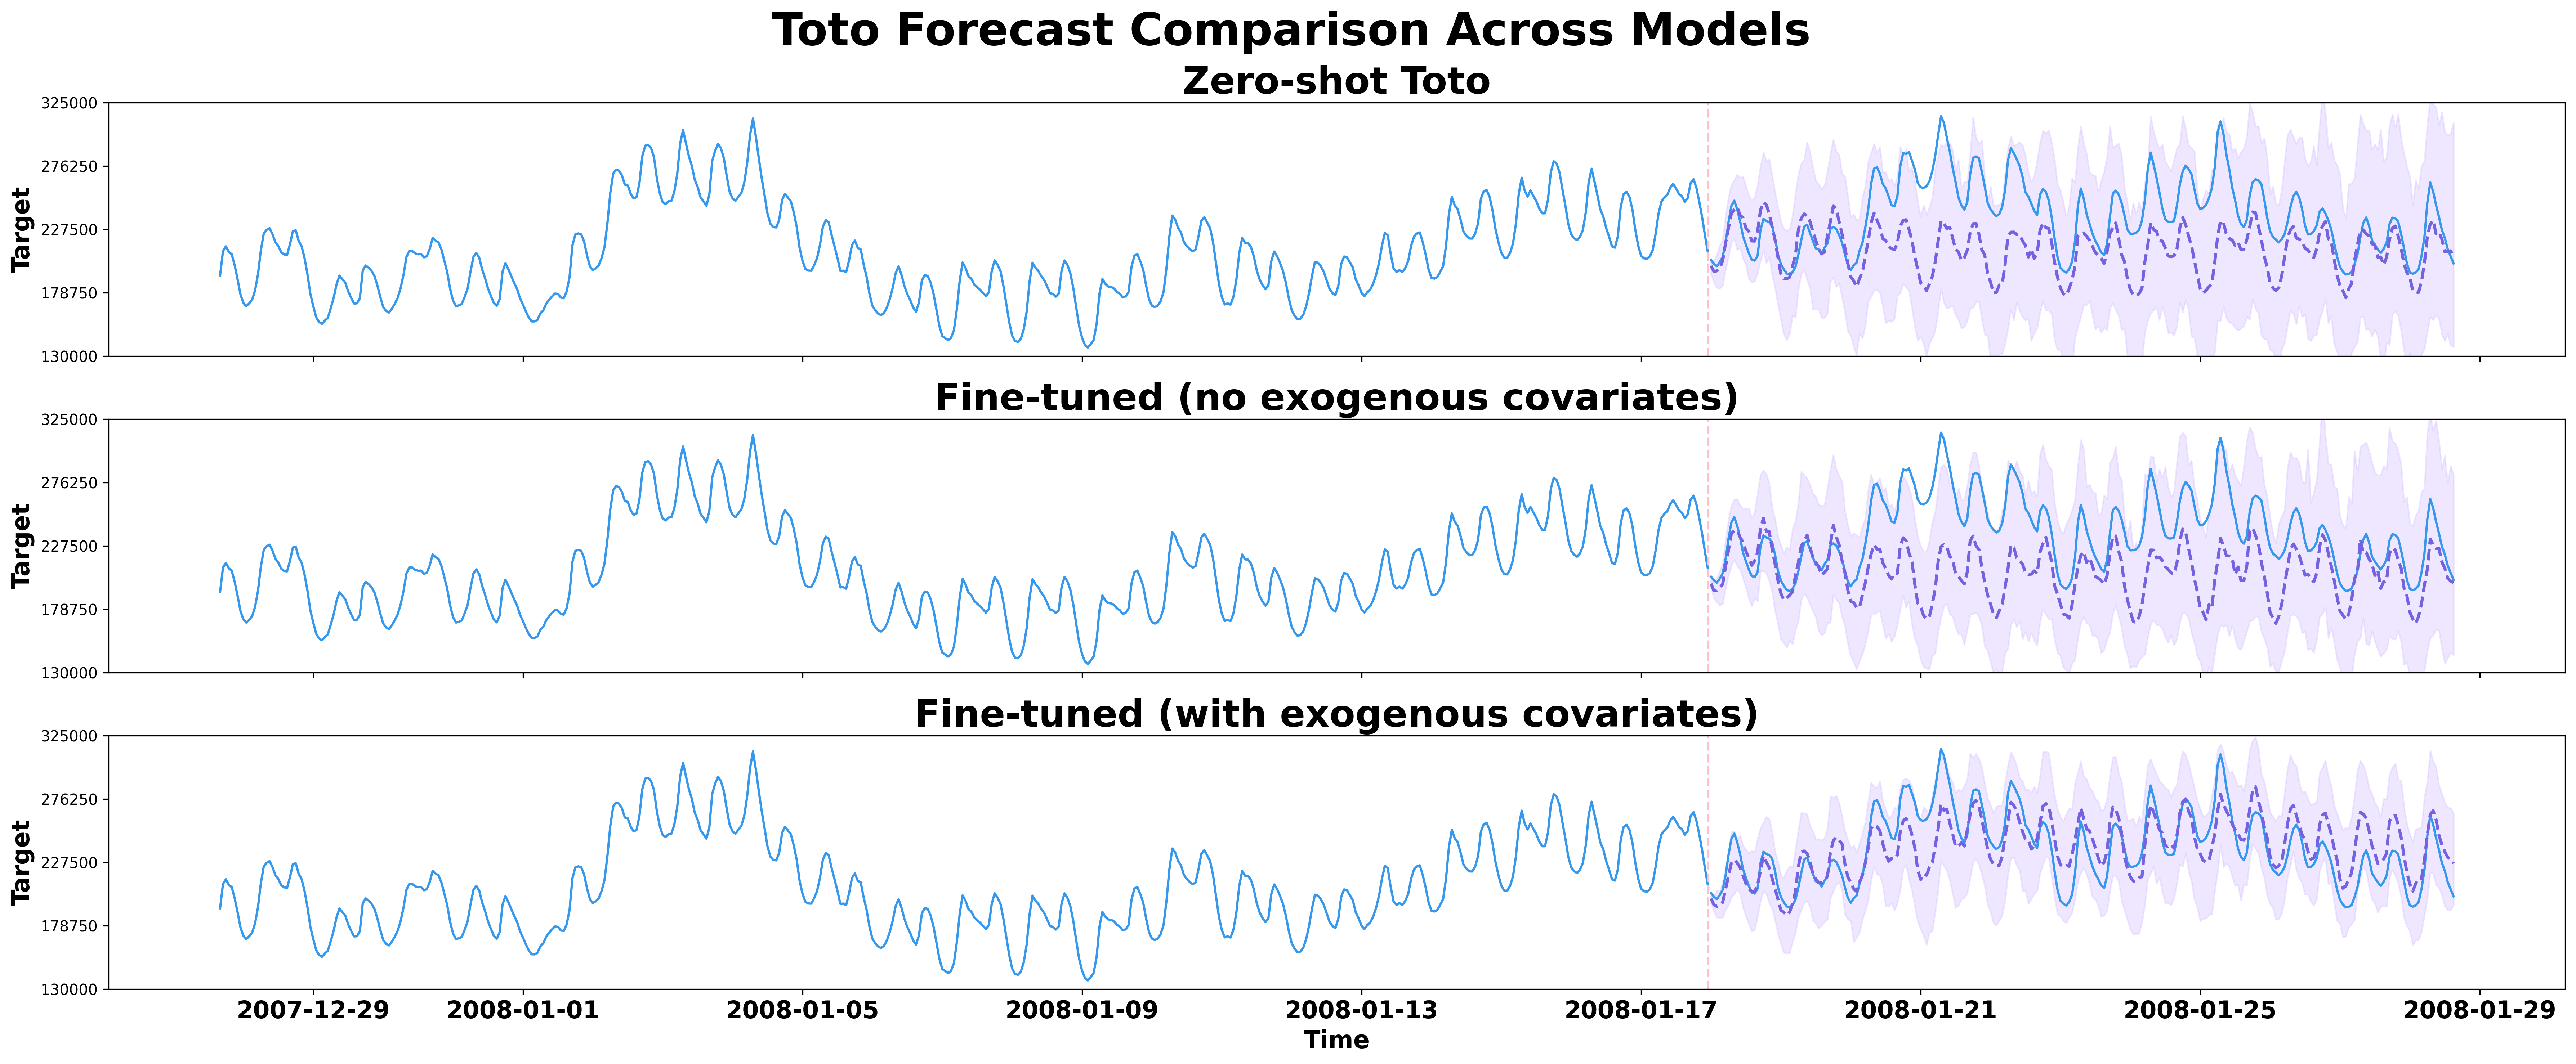

In [19]:
var_names = ["Target"]
exogenous_mask = [False, True, True, True]

plot_toto_forecasts_multi(
    forecasts=[
        forecast_unfinetuned,
        forecast_wo_ev,
        forecast_with_ev,
    ],
    contexts=[
        context_series_wo_ev,   # same as for fine-tuned no-ev
        context_series_wo_ev,
        context_series_with_ev,
    ],
    futures=[
        future_series_wo_ev,
        future_series_wo_ev,
        future_series_with_ev,
    ],
    timestamps=[
        timestamps_str_context.reshape(1, -1),
        timestamps_str_context.reshape(1, -1),
        timestamps_str_context.reshape(1, -1),
    ],
    target_timestamps=[
        timestamps_str_future.reshape(1, -1),
        timestamps_str_future.reshape(1, -1),
        timestamps_str_future.reshape(1, -1),
    ],
    var_names=var_names,
    model_names=[
        "Zero-shot Toto",
        "Fine-tuned (no exogenous covariates)",
        "Fine-tuned (with exogenous covariates)",
    ],
    exogenous_mask=exogenous_mask,
    ylim=(130000, 325000),
)
plt.show()

## 6. Evaluation

We quantitatively evaluate all three models using standard forecasting metrics from GluonTS:

| Metric | Description |
|--------|-------------|
| **abs_error** | Mean Absolute Error (MAE) — average absolute deviation from ground truth |
| **mean_wQuantileLoss** | Weighted Quantile Loss — measures probabilistic calibration across quantiles |
| **MASE** | Mean Absolute Scaled Error — MAE normalized by the in-sample naive forecast error |

We evaluate across multiple rolling windows in the test split and compute both per-window ranks and median aggregated metrics.

### 6.1 Evaluation Helper Functions

In [20]:
from toto.evaluation.fev.evaluate import evaluate_model
from toto.scripts.benchmark_finetuning import aggregate_results

In [ ]:
# Evaluate all models using sliding windows on the test split
results_unfinetuned = evaluate_model(lightning_module_unfinetuned, datamodule_wo_ev._view.hf_dataset, datamodule_wo_ev._view._context_length, horizon, seasonality, stride=horizon, add_exogenous_variables=False)
results_finetuned_no_ev = evaluate_model(lightning_module_wo_ev, datamodule_wo_ev._view.hf_dataset, datamodule_wo_ev._view._context_length, horizon, seasonality, stride=horizon, add_exogenous_variables=False)
results_finetuned_with_ev = evaluate_model(lightning_module_with_ev, datamodule_with_ev._view.hf_dataset, datamodule_with_ev._view._context_length, horizon, seasonality, stride=horizon, add_exogenous_variables=True)

### 6.2 Aggregated Results

Finally, we compute the median of each metric across all evaluation windows. This provides a single summary score for each model, making it easy to compare overall performance.


In [22]:
import pandas as pd

# aggregate results 
aggregated_unfinetuned = aggregate_results(results_unfinetuned)
aggregated_finetuned_no_ev = aggregate_results(results_finetuned_no_ev)
aggregated_finetuned_with_ev = aggregate_results(results_finetuned_with_ev)

all_models_results = {
    "zero_shot": aggregated_unfinetuned,
    "finetuned_no_ev": aggregated_finetuned_no_ev,
    "finetuned_with_ev": aggregated_finetuned_with_ev,
}

pd.DataFrame(all_models_results)

,zero_shot,finetuned_no_ev,finetuned_with_ev
abs_error,2.178573e+07,1.964083e+07,1.430377e+07
mean_wQuantileLoss,9.062997e-02,8.313183e-02,5.950023e-02
MASE,1.030820e+00,9.431199e-01,7.191113e-01
